# Libraries

In [1]:
import tensorflow as tf
import librosa as lr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import scipy.stats as sc

2024-02-01 15:39:59.550028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 15:40:00.724899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset creation

In [2]:
bath = {'path' : "./Sounds/Taking a bath/", 'label' : "taking_a_bath"}
teeth = {'path' : "./Sounds/Brushing teeth/", 'label' : "brushing_teeth"}
coffee = {'path' : "./Sounds/Making coffee/", 'label' : "making_coffee"}
cooking1 = {'path' : "./Sounds/Cooking/Frying an egg/", 'label' : "cooking"}
cooking2 = {'path' : "./Sounds/Cooking/Stewing meat/", 'label' : "cooking"}
no_act = {'path' : "./Sounds/No activity/", 'label' : "no_activity"}
microwave = {'path' : "./Sounds/Using microwave oven/", 'label' : "using_microwave_oven"}
dishes = {'path' : "./Sounds/Washing dishes/", 'label' : "washing_dishes"}
hands = {'path' : "./Sounds/Washing hands/", 'label' : "washing_hands"}

data = (bath,teeth,coffee,cooking1,cooking2,no_act,microwave,dishes,hands)

In [3]:
def label_to_num(label):

    mapping = {"taking_a_bath":0,\
                "brushing_teeth":1,\
                "making_coffee":2,\
                "cooking":3,\
                "using_microwave_oven":4,\
                "washing_dishes":5,\
                "washing_hands":6,\
                "no_activity":7}

    return mapping[label]

def num_to_label(num):

    mapping = {0:"taking_a_bath",\
               1:"brushing_teeth",\
               2:"making_coffee",\
               3:"cooking",\
               4:"using_microwave_oven",\
               5:"washing_dishes",\
               6:"washing_hands",\
               7:"no_activity"}

    return mapping[num]


def split_array_equal_parts(arr, seconds, sampling_rate):

    part_size = seconds * sampling_rate
    
    num_elements = len(arr)
    num_parts = (num_elements + part_size - 1) // part_size
    result = [arr[i * part_size: (i + 1) * part_size] for i in range(num_parts)]
    
    while len(result[-1]) < part_size:
        last_part = result[-1]
        result[-1] = np.concatenate((last_part,last_part))[:part_size]

    return result

def trim_array(arr,value):
    
    trim_amount = int(len(arr) * value)

    trimmed_arr = arr[trim_amount:-trim_amount]

    return trimmed_arr

In [4]:
dataset = pd.DataFrame(columns=['sound_data','sampling_rate','label','duration'],dtype=object)

In [5]:
index = 0
for category in tqdm(data):
    file_names = os.listdir(category['path'])
    for file_name in file_names:
        sound = lr.load(category['path']+file_name, sr=None, mono=False)
        dataset.loc[index,'sound_data'] = sound[0][0] if type(sound[0][0]) == np.ndarray else sound[0]
        dataset.loc[index,'label'] = category['label']
        dataset.loc[index,'sampling_rate'] = sound[1]
        dataset.loc[index,'duration'] = lr.get_duration(y=dataset.loc[index,'sound_data'], sr=dataset.loc[index,'sampling_rate'])
        index += 1

100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


In [17]:
dataset

,sound_data,sampling_rate,label,duration
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,taking_a_bath,480.417959
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,taking_a_bath,656.222041
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,taking_a_bath,480.417959
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,taking_a_bath,594.311837
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,taking_a_bath,413.988571
...,...,...,...,...
62,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,washing_hands,30.4
63,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,washing_hands,68.010658
64,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,washing_hands,52.757324
65,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,washing_hands,101.802653


In [7]:
dataset.duration.sum()

12217.700265731293

In [8]:
dataset.sampling_rate.unique()

array([44100, 16000], dtype=object)

## Standardize duration to 1 minute

In [8]:
dataset_std = pd.DataFrame(columns=['sound_data','sampling_rate','label','duration'],dtype=object)

In [9]:
index2 = 0

for index in tqdm(dataset.index):
    
    sound = dataset.loc[index,'sound_data']
    sampling_rate = dataset.loc[index,'sampling_rate']
    label = dataset.loc[index,'label']

    parts = split_array_equal_parts(sound, 60, 44100)
    
    for part in parts:

        dataset_std.loc[index2,'sound_data'] = part
        dataset_std.loc[index2,'sampling_rate'] = sampling_rate
        dataset_std.loc[index2,'label'] = label
        dataset_std.loc[index2,'duration'] = lr.get_duration(y=part, sr=sampling_rate)

        index2 += 1

100%|██████████| 67/67 [00:01<00:00, 51.58it/s] 


In [10]:
dataset_std.groupby(['label']).count().sound_data

label
brushing_teeth          29
cooking                 27
making_coffee           45
no_activity              7
taking_a_bath           76
using_microwave_oven     9
washing_dishes          26
washing_hands           21
Name: sound_data, dtype: int64

In [11]:
dataset_std.duration.sum()

14926.875

In [10]:
del dataset

## Standardize duration to 10 seconds

In [6]:
dataset_std = pd.DataFrame(columns=['sound_data','sampling_rate','label','duration'],dtype=object)

In [7]:
index2 = 0

for index in tqdm(dataset.index):
    
    sound = dataset.loc[index,'sound_data']
    sampling_rate = dataset.loc[index,'sampling_rate']
    label = dataset.loc[index,'label']

    parts = split_array_equal_parts(sound, 10, 44100)
    
    for part in parts:

        dataset_std.loc[index2,'sound_data'] = part
        dataset_std.loc[index2,'sampling_rate'] = sampling_rate
        dataset_std.loc[index2,'label'] = label
        dataset_std.loc[index2,'duration'] = lr.get_duration(y=part, sr=sampling_rate)

        index2 += 1

100%|██████████| 67/67 [00:00<00:00, 148.12it/s]


In [20]:
dataset_std.groupby(['label']).count().sound_data

label
brushing_teeth          142
cooking                 138
making_coffee           254
no_activity              19
taking_a_bath           437
using_microwave_oven     43
washing_dishes          140
washing_hands            83
Name: sound_data, dtype: int64

In [11]:
dataset_std.duration.sum()

14926.875

In [8]:
del dataset

# Feature extraction

In [9]:
features = pd.DataFrame(columns=('chromagram','mfcc', 'mean', 'median', 'std', 'var'),dtype=object)

In [10]:
for index in tqdm(dataset_std.index):
    features.loc[index,'mfcc'] = lr.feature.mfcc(y=dataset_std.loc[index,'sound_data'],sr=dataset_std.loc[index,'sampling_rate'], n_mfcc=12)

for index in tqdm(dataset_std.index):
    features.loc[index,'chromagram'] = lr.feature.chroma_stft(y=dataset_std.loc[index,'sound_data'],sr=dataset_std.loc[index,'sampling_rate'])
    

for index in tqdm(dataset_std.index):
    features.loc[index,'mean'] = np.mean(dataset_std.loc[index,'sound_data'])
    features.loc[index,'median'] = np.median(dataset_std.loc[index,'sound_data'])
    features.loc[index,'std'] = np.std(dataset_std.loc[index,'sound_data'])
    features.loc[index,'var'] = np.std(dataset_std.loc[index,'sound_data'])**2
    features.loc[index,'kurtois'] = sc.kurtosis(dataset_std.loc[index,'sound_data'])
    features.loc[index,'skewness'] = sc.mstats.skew(dataset_std.loc[index,'sound_data'])
    features.loc[index,'CV'] = sc.variation(dataset_std.loc[index,'sound_data'])
    features.loc[index,'invCV'] = sc.variation(dataset_std.loc[index,'sound_data'])**(-1)
    features.loc[index,['1p','5p','25p','50p','75p','95p','99p']] = np.percentile(dataset_std.loc[index,'sound_data'],[1,5,25,50,75,95,99])
    trimmed_sound = trim_array(dataset_std.loc[index,'sound_data'],0.05)
    features.loc[index,'trimmed_mean'] = np.mean(trimmed_sound)
    features.loc[index,'label'] = label_to_num(dataset_std.loc[index,'label'])


100%|██████████| 1256/1256 [00:31<00:00, 39.70it/s]


In [17]:
features

,chromagram,mfcc,mean,median,std,var,kurtois,skewness,CV,invCV,1p,5p,25p,50p,75p,95p,99p,trimmed_mean,label
0,"[[0.0, 0.0, 0.6566912, 1.0, 0.5785515, 0.97448...","[[-991.4288, -991.4288, -991.4288, -991.4288, ...",-0.000011,0.0,0.002592,0.000007,21.433105,0.088218,-231.225632,-0.004325,-0.008023,-0.003376,-0.000846,0.000000,0.000814,0.003351,0.008012,-1.154664e-05,0.0
1,"[[0.8961353, 0.9455121, 0.89576524, 0.84305924...","[[-468.7298, -422.77975, -412.57513, -416.7394...",-0.000008,0.000005,0.011822,0.00014,12.461391,-0.020590,-1496.804688,-0.000668,-0.038354,-0.018260,-0.001674,0.000005,0.001624,0.018335,0.038209,-8.323434e-06,0.0
2,"[[0.84451187, 0.9060918, 1.0, 1.0, 1.0, 1.0, 0...","[[-340.64792, -310.3327, -316.2259, -317.84622...",0.0,0.000012,0.011755,0.000138,1.256730,-0.000802,71176.156250,0.000014,-0.028465,-0.018912,-0.007489,0.000012,0.007498,0.018898,0.028313,-2.125495e-07,0.0
3,"[[1.0, 0.97402287, 1.0, 1.0, 0.7421579, 0.7490...","[[-335.9446, -302.80118, -308.70343, -307.8846...",-0.0,0.000024,0.013565,0.000184,0.668624,-0.000258,-58454.738281,-0.000017,-0.032605,-0.022001,-0.008795,0.000024,0.008777,0.022019,0.032789,-2.251435e-07,0.0
4,"[[0.48251623, 0.6882827, 0.83859205, 1.0, 1.0,...","[[-366.60284, -333.1754, -337.181, -331.55566,...",-0.0,0.000017,0.012822,0.000164,0.253562,-0.006486,-44603.449219,-0.000022,-0.030404,-0.021007,-0.008478,0.000017,0.008494,0.020982,0.030264,-3.868338e-07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,"[[0.78781575, 0.80503255, 0.6545302, 0.9573143...","[[-543.2512, -525.5854, -530.60583, -537.08514...",-0.000144,-0.000107,0.021276,0.000453,149.067702,0.157907,-147.335449,-0.006787,-0.060433,-0.011502,-0.001527,-0.000107,0.001305,0.011502,0.057658,-1.544673e-04,6.0
1252,"[[0.568025, 0.47059125, 0.4681215, 0.66785127,...","[[-347.37836, -312.11456, -302.18222, -334.443...",-0.000224,-0.000003,0.023464,0.000551,105.990129,-0.313151,-104.808212,-0.009541,-0.069714,-0.023471,-0.003336,-0.000003,0.003373,0.021625,0.066940,-2.309529e-04,6.0
1253,"[[0.6299407, 0.7513651, 0.9385581, 0.98340833,...","[[-304.68146, -287.6423, -322.68594, -341.7352...",-0.000144,-0.000134,0.027556,0.000759,31.812893,0.057020,-191.210922,-0.005230,-0.088834,-0.032134,-0.004715,-0.000134,0.004452,0.031710,0.088083,-1.237685e-04,6.0
1254,"[[0.68272763, 0.52109104, 0.40365675, 0.382855...","[[-315.04364, -293.036, -308.32523, -331.92633...",-0.000129,-0.000107,0.012538,0.000157,50.312258,0.249686,-97.520958,-0.010254,-0.037759,-0.013960,-0.002736,-0.000107,0.002506,0.013748,0.037107,-1.300886e-04,6.0


In [11]:
del dataset_std

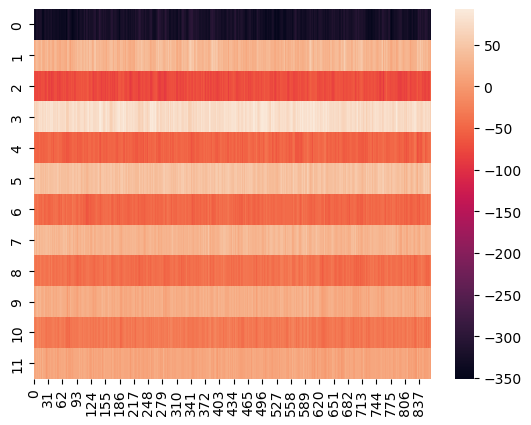

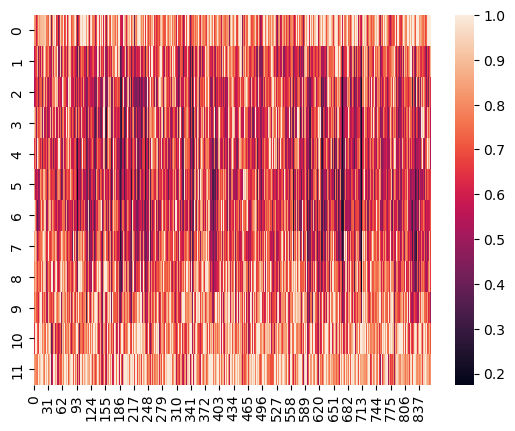

In [12]:
i = 7
ax = sns.heatmap(features.loc[i].mfcc)
plt.show()
ax = sns.heatmap(features.loc[i].chromagram)
plt.show()

In [20]:
len(features.mfcc[0][0])

862

# Feature normalization

In [21]:
def normalize_mfcc(mfcc_col):

    i = 0

    all_elems = [np.nan]*((1256*12*862) if len(mfcc_col) > 240 else (240*12*5168))
    
    for mfcc in mfcc_col:
        for level in mfcc:
            for value in level:
                all_elems[i] = value
                i+=1

    mean = np.mean(all_elems)
    std = np.std(all_elems)

    new_col = mfcc_col.apply(lambda x : (x - mean)/std)
    
    return new_col
        

In [22]:
features_norm = pd.DataFrame(columns=('chromagram', 'mfcc', 'mean', 'median', 'std', 'var', 'kurtois', 'skewness', 'CV','invCV','1p','5p','25p','50p','75p','95p','99p','trimmed_mean','label'),dtype=object)

In [23]:
features_norm['chromagram'] = normalize_mfcc(features.chromagram)
features_norm['mfcc'] = normalize_mfcc(features.mfcc)

for col in features.columns[2:-1]:

    features_norm[col] = (features[col] - features[col].mean()) / features[col].std()

features_norm['label'] = features['label']
    

In [24]:
features_norm

,chromagram,mfcc,mean,median,std,var,kurtois,skewness,CV,invCV,1p,5p,25p,50p,75p,95p,99p,trimmed_mean,label
0,"[[-2.2023833, -2.2023833, 0.3103507, 1.6239722...","[[-7.714706, -7.714706, -7.714706, -7.714706, ...",0.07422,0.287471,-0.880905,-0.530121,-0.164742,0.068701,0.034206,-0.208925,0.770419,0.863899,0.949937,0.287471,-0.946671,-0.866215,-0.769164,0.055506,0.0
1,"[[1.2265488, 1.4154822, 1.225133, 1.0234611, 1...","[[-3.5351353, -3.1677127, -3.0861151, -3.11941...",0.144015,0.373935,-0.113761,-0.304015,-0.191344,0.012187,-0.019820,0.290823,-0.061717,-0.056489,0.768563,0.373935,-0.769793,0.063582,0.057344,0.130842,0.0
2,"[[1.0290194, 1.264646, 1.6239722, 1.6239722, 1...","[[-2.5109756, -2.2685711, -2.3156939, -2.32865...",0.313966,0.493967,-0.119336,-0.306702,-0.224566,0.022465,3.082514,0.384049,0.209596,-0.096848,-0.506182,0.493967,0.511710,0.098503,-0.213515,0.320416,0.0
3,"[[1.6239722, 1.5245744, 1.6239722, 1.6239722, ...","[[-2.4733672, -2.208348, -2.2555432, -2.248996...",0.305594,0.719924,0.031093,-0.228819,-0.226310,0.022748,-2.451296,0.379791,0.096010,-0.287830,-0.792356,0.719924,0.790698,0.292197,-0.090995,0.320122,0.0
4,"[[-0.35610464, 0.4312311, 1.006368, 1.6239722,...","[[-2.7185144, -2.4512243, -2.4832535, -2.43827...",0.304427,0.589384,-0.030698,-0.262158,-0.227541,0.019512,-1.859999,0.379065,0.156391,-0.226362,-0.722852,0.589384,0.728797,0.227857,-0.160102,0.316343,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,"[[0.81207985, 0.87795746, 0.30208206, 1.460641...","[[-4.1310186, -3.9897602, -4.0299044, -4.08171...",-2.73301,-1.605973,0.671907,0.227702,0.213705,0.104897,0.037787,-0.545460,-0.667450,0.361422,0.800710,-1.605973,-0.839440,-0.360446,0.589646,-3.284957,6.0
1252,"[[-0.028917724, -0.40173388, -0.411184, 0.3530...","[[-2.564793, -2.282819, -2.2033987, -2.4613612...",-4.408027,0.240908,0.853789,0.39409,0.085976,-0.139767,0.039603,-0.921841,-0.922071,-0.378740,0.404177,0.240908,-0.388332,0.267747,0.843713,-5.072644,6.0
1253,"[[0.20799373, 0.67260677, 1.3888737, 1.5604866...","[[-2.223383, -2.0871356, -2.3673491, -2.51967,...",-2.726892,-2.088476,1.193863,0.748865,-0.133965,0.052497,0.035914,-0.332615,-1.446635,-0.914513,0.102002,-2.088477,-0.152896,0.893563,1.422384,-2.567440,6.0
1254,"[[0.40997535, -0.2085037, -0.657849, -0.737441...","[[-2.3062403, -2.1302643, -2.252519, -2.441236...",-2.399276,-1.600444,-0.054278,-0.274385,-0.079113,0.152567,0.039914,-1.019280,-0.045394,0.209417,0.535603,-1.600444,-0.577507,-0.221060,0.027190,-2.715157,6.0


In [23]:
del features


In [25]:
features_norm.to_json('./features_norm_short.json')

# Statistical features visualization

In [6]:
features_norm_short = pd.read_json('./features_norm_short.json')

In [11]:
dataset = features_norm_short.drop('chromagram', axis=1).drop('mfcc', axis=1).drop('label', axis=1)

In [64]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

# Reformat and view results
loadings = pca.fit_transform(dataset)


In [65]:
x = [x[0] for x in loadings]
y = [x[1] for x in loadings]
z = [x[2] for x in loadings]
t_pred = [x[1] for x in results.values]
t_true = features_norm_short.label

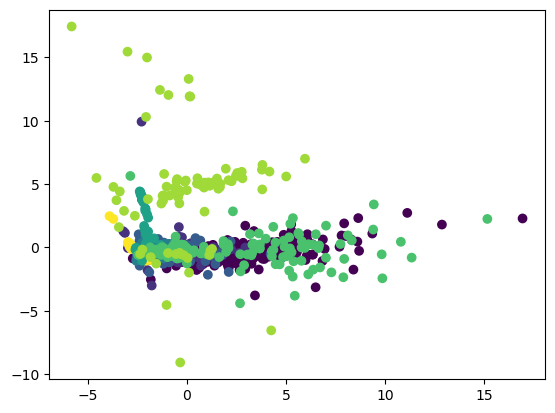

In [66]:
plt.scatter(x,y, c=t_true)
plt.show()

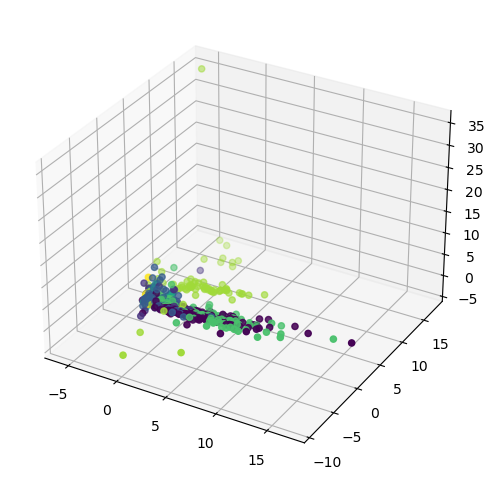

In [73]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, c=t_true, label=t_true)

plt.show()

In [2]:
features_norm = pd.read_json('./features_norm.json')

In [3]:
features_norm

,chromagram,mfcc,mean,median,std,var,kurtois,skewness,CV,invCV,1p,5p,25p,50p,75p,95p,99p,trimmed_mean,label
0,"[[-2.1071684361, -2.1071684361, -0.37331357600...","[[-5.7688217163, -5.7688217163, -5.7688217163,...",0.322482,0.348891,-0.217598,-0.414548,-0.405183,0.067885,-0.062596,0.357992,0.210450,-0.165821,-0.158567,0.348891,0.164698,0.166439,-0.209177,0.344254,0
1,"[[0.8273255825, 0.24335813520000002, -0.451372...","[[-2.4463603497, -2.241499424, -2.3624687195, ...",0.379504,0.326000,-0.277829,-0.448538,-0.410532,0.072450,-0.195643,0.385661,0.320351,-0.068492,-0.521642,0.326000,0.524695,0.071036,-0.318421,0.400924,0
2,"[[-0.3449971676, 0.9652983546, 1.6003433465999...","[[-2.9551086426, -2.7298481464, -2.8002011776,...",0.328958,0.308694,-0.443022,-0.531475,-0.384864,0.074648,-0.054475,0.351348,0.371972,0.274033,0.103320,0.308694,-0.096043,-0.272764,-0.371938,0.340913,0
3,"[[1.6170195341, 0.40295875070000003, 0.7073997...","[[-2.7783944607, -2.5615572929, -2.57311224940...",0.349310,0.324180,-0.360477,-0.491917,-0.405258,0.073696,-0.079847,0.367232,0.378728,0.087428,-0.339149,0.324181,0.343564,-0.085294,-0.377695,0.367282,0
4,"[[1.5261234045, 0.6087349653, -0.2201282680000...","[[-2.3439702988, -2.0923230648, -2.0434062481,...",0.341754,0.303503,-0.058085,-0.314849,-0.366222,0.068695,-0.091955,0.371493,0.104079,-0.109976,-0.516780,0.303503,0.519518,0.112041,-0.098523,0.348127,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,"[[-0.8868954182000001, 0.8686407804, -0.460512...","[[-4.1314520836, -4.1314520836, -4.1312880516,...",-4.874060,-2.889303,1.652218,1.637415,-0.095749,0.076534,-0.008699,-0.546518,-1.211873,-0.407006,0.390306,-2.889302,-0.470184,0.369008,1.148103,-4.745667,6
236,"[[-0.5568587184, 1.007191062, 0.88938200470000...","[[-5.0585198402, -5.0585198402, -5.0206246376,...",-4.677212,-2.447299,1.724690,1.755827,-0.222794,0.092616,-0.008850,-0.489305,-1.781068,-1.050774,0.342144,-2.447299,-0.408094,0.975877,1.743461,-4.738840,6
237,"[[-0.5146341324, -0.0782881901, -0.4565278292,...","[[-4.3758606911, -4.1834540367, -4.0888028145,...",-2.598242,-1.692931,1.501813,1.400930,-0.235440,0.062796,-0.010266,-0.168486,-1.571491,-0.846376,0.342478,-1.692931,-0.370569,0.796105,1.572208,-3.006150,6
238,"[[0.2184612155, 1.6170195341, 0.95531129840000...","[[-5.2221503258, -5.2221503258, -5.2053909302,...",-3.942888,-2.593807,0.922734,0.607107,-0.287922,0.077012,-0.008490,-0.638595,-1.091646,-0.784178,0.264424,-2.593807,-0.324513,0.744566,1.066499,-3.826217,6
